In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexholder","key":"d2922de94720de89ce73474159860152"}'}

In [2]:
# Make directory and copy.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#!pip install kaggle # Install kaggle.

# Change access permissions.
!chmod 600 /root/.kaggle/kaggle.json

#!kaggle datasets list # Lists kaggle datasets.

# Download using Kaggle API.
!kaggle competitions download -c brighton-a-memorable-city

# Unzip data
!unzip additional_training.csv
!unzip training.csv
!unzip testing.csv

# List files in dir.
# !ls

  0% 0.00/81.9k [00:00<?, ?B/s]
100% 81.9k/81.9k [00:00<00:00, 31.0MB/s]
  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 111MB/s]
 64% 9.00M/14.2M [00:00<00:00, 22.6MB/s]
100% 14.2M/14.2M [00:00<00:00, 31.9MB/s]
  0% 0.00/19.6k [00:00<?, ?B/s]
100% 19.6k/19.6k [00:00<00:00, 19.5MB/s]
 91% 78.0M/85.7M [00:01<00:00, 32.3MB/s]
100% 85.7M/85.7M [00:01<00:00, 50.8MB/s]
  0% 0.00/30.0 [00:00<?, ?B/s]
100% 30.0/30.0 [00:00<00:00, 30.6kB/s]
Archive:  additional_training.csv.zip
  inflating: additional_training.csv  
Archive:  training.csv.zip
  inflating: training.csv            
Archive:  testing.csv.zip
  inflating: testing.csv             


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.impute import SimpleImputer


from sklearn.utils import shuffle, resample

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Unused
# from imblearn.under_sampling import TomekLinks
# from sklearn.feature_selection import VarianceThreshold
# from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

Using TensorFlow backend.


In [0]:
train = pd.read_csv("/content/training.csv")
test = pd.read_csv("/content/testing.csv")
test_proportions = pd.read_csv("/content/test_proportions.csv")
additional_train = pd.read_csv("/content/additional_training.csv")
annotation_confidence = pd.read_csv("/content/annotation_confidence.csv")

<br>

In [0]:
#@title Function Plot Bar Graphs

# Graph-rep. Functions.

# Plot bar.
def plotbargraph(trn, bars=True):

  # Data representation:

  # Get all observed predictions 0 / 1.
  trn_observed = trn.iloc[:, -1]
  # .values()
  y_ = trn_observed.to_numpy(copy=True)

  # Training ---
  trn_c0 = np.count_nonzero(y_ == 0)
  trn_c1 = np.count_nonzero(y_ == 1)

  autolabel_vals = [trn_c0,trn_c1] # Hold vals for rect labels.

  trn_c0 = round((trn_c0/len(y_)*100),2)
  trn_c1 = round((trn_c1/len(y_)*100),2)
  trn_bar = [trn_c0,trn_c1] # Hold vals for bar plot.


  # Testing ---
  tst_c0 = float(test_proportions.iloc[0,0][:6])

  # Hold vals for rect labels.
  autolabel_vals.append(tst_c0*len(test))
  autolabel_vals.append((1-tst_c0)*len(test))

  tst_c0 = round((tst_c0*100),2)
  tst_c1 = 100 - tst_c0
  tst_bar = [tst_c0,tst_c1] # Hold vals for bar plot.


  print("Proportions")
  print("Training data:  Class0: {}%   Class1: {}%".format(trn_c0,trn_c1) +
        "   Proportion: {} : 1".format(round((trn_c0/trn_c1),4)))
  print("Testing data:   Class0: {}%   Class1: {}%".format(tst_c0,tst_c1) + 
        "   Proportion: {} : 1".format(round((tst_c0/tst_c1),4)))

  if bars:
    # Bar Plot.
    labels = ["Class0 - Memorable", "Class1 - Non Memorable"]
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, trn_bar, width, label='Train')
    rects2 = ax.bar(x + width/2, tst_bar, width, label='Test')

    ax.set_ylabel("PERCENTAGE PROPORTION")
    ax.set_ylim([0,100])
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    xyz = list()
    ############
    '''https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html'''
    def autolabel(rects):
      for i, rect in enumerate(rects):
        height = rect.get_height()
        xy=(rect.get_x() + rect.get_width() / 2, height)
        xyz.append(xy)
      for i, (coord, val) in enumerate(zip(xyz,autolabel_vals)):
        ax.annotate(s=round(val),
                    xy=coord,
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    ############


    fig.tight_layout()

    plt.show()

In [0]:
#@title Function Scatter Graphs
# Plot scatter.
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', '*']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [0]:
#@title Function - Up Sample using Sklearn Resampler Class
def resample_up(trn_total):
  # RESAMPLING.                             
  # ----------- Up sampling minority class.

  #train = pd.read_csv("/content/training.csv")

  # Minority class.
  c = 0 
  minority = trn_total.loc[trn_total["prediction"] == c]

  # Num. of samples equal across classes.
  num = len(trn_total) - 2 * len(minority)
  # Increase to match test data ratio if wanted.
  num = round(num * 1.7)

  print("{} rows added to trning data with class{} scores.".format(num, c))

  class0_upsampled = resample(minority,
                            replace=True,
                            n_samples=num,
                            random_state=seed
                            )

  # Concat new class0 sample and original trn.
  trn_total = pd.concat([trn_total, class0_upsampled])

  # Shuffle. 
  trn_total = shuffle(trn_total, random_state=seed)


  # Fix INDEX OF trn_total DATA.
  trn_total = trn_total.reset_index(drop=True).reset_index().drop(columns=["ID"])
  trn_total.columns.values[0] = "ID"
  trn_total["ID"] += 1


  # Update target array.
  # Get all observed predictions 0 / 1.
  trn_total_observed = trn_total.iloc[:, -1]
  # .values()
  trn_total_y = trn_total_observed.to_numpy(copy=True)

  return trn_total, trn_total_observed, trn_total_y

In [0]:
#@title Function - Estimate Accuracy from Proportions
# Calculate extremely rough "accuracy" from proportion of data correct.
def estimate(preds_final):
  class_0 = 0
  class_1 = 0

  for val in preds_final:
    if val == 0:
      class_0 += 1
    elif val == 1:
      class_1 += 1

  total = len(preds_final)

  pred_0 = round((class_0 / total), 4)
  pred_1 = round((class_1 / total), 4) 

  actual_0 = float(test_proportions.iloc[0,0][:6])
  actual_1 = round((1 - actual_0),4)

  dif = abs(pred_0 - actual_0)
  percent_dif = dif / np.mean([pred_0,actual_0]) * 100

  print("Class 0 Non memorable: \nPredicted proportion: {} \nActual proportion:    {}\n".format(pred_0,actual_0))
  print("Class 1 Memorable: \nPredicted proportion: {} \nActual proportion:    {}\n".format(pred_1,actual_1))
  print("Percentage difference pred_0 and actual_0 is:\n{}%\nDifference of:\n{}".format(round(percent_dif,2), round(dif,4)))

In [0]:
#@title Function - Evaluate Classifier Performance

def classifier_performance(data_split_list, clf, keras_model=0, epochs=4):

  # Pull split data
  X_train, X_test, y_train, y_test = data_split_list
  
  if keras_model:
    # Fit classifier to data
    clf.fit(X_train,y_train,epochs=epochs)
    # Predictions.
    test_predictions = clf.predict(X_test)
    test_predictions = np.around(test_predictions).flatten().astype("int")
  else:
    # Fit classifier to data
    clf.fit(X_train,y_train)
    # Predictions.
    test_predictions = clf.predict(X_test)

  estimate(test_predictions)

  print("\nClassification Report:")
  target_names = ["Class0", "Class1"]
  print(classification_report(y_test, test_predictions, target_names=target_names))

  print()
  print("\nConfusion Matrix")
  df = pd.crosstab(y_test, test_predictions, rownames=['True'], colnames=['Predicted'], margins=True)
  display(df)
  
  print()
  return df.to_latex()

In [0]:
#@title Function - Plot learning curves using Sklearn's script

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


<br>

In [0]:
#@title Set up Training Data 
# START--------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
train = pd.read_csv("/content/training.csv")
# ------ Set up observed predictions.

# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 
# Throughout this notebook classifiers etc are fed numpy arrays. This was due to
# certain trial classifiers prefering np array to pd etc DataFrames.

# Random seed.
seed = 260498

Proportions
Training data:  Class0: 15.38%   Class1: 84.62%   Proportion: 0.1818 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


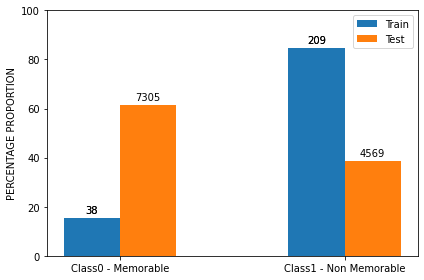

In [10]:
#@title Plot Original Data Distribution
# BAR
plotbargraph(train)

# # PCA -----
# pca = PCA(n_components=2)

# hold = train.iloc[:,1:-1]

# X_pca = pca.fit_transform(hold)

# plot_2d_space(X_pca, y)

# len(X_pca)

In [11]:
#@title Input Additional Data

additional_obsv = additional_train.iloc[:,-1]
# Fastest way.
null_add = additional_train.isnull().to_numpy().any()
null_y = additional_obsv.isnull().to_numpy().any()
print("NaN values across all columns: {}".format(null_add))
print("NaN values in predictions column: {}\n".format(null_y))

# Possible imputer strategies to test out.
strats = ["mean","median","most_frequent","constant"]
# Create Simple Imputer.
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
# fit_transform() additional_data.
holder = imp.fit_transform(additional_train)

# Convert back to DF and overwrite.
additional_train = pd.DataFrame(holder)

# Re-check for NaN values.
null_add = additional_train.isnull().to_numpy().any()
print("NaN values across all columns now: {}".format(null_add))

# Rename additional train columns to match og. train.
additional_train = pd.DataFrame(data=additional_train.values, columns=train.columns)

# var to hold complete dataframe with missing values replaced using set strategy.
train_total = pd.concat([train,additional_train])

train_total_observed = train_total.iloc[:,-1] ####TOTAL DATA PREDICTIONS.
train_total_y = train_total_observed.to_numpy()

NaN values across all columns: True
NaN values in predictions column: False

NaN values across all columns now: False


Proportions
Training data:  Class0: 12.98%   Class1: 87.02%   Proportion: 0.1492 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


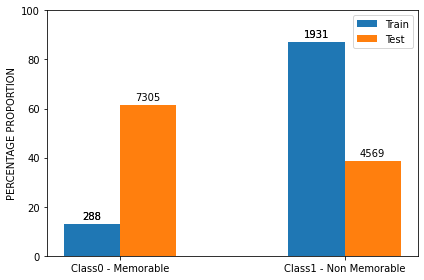

In [12]:
#@title Plot Additional Data Distribution

# BAR
plotbargraph(additional_train)

# # PCA -----
# pca = PCA(n_components=2)

# hold = additional_train.iloc[:,1:-1]

# X_pca = pca.fit_transform(hold)

# plot_2d_space(X_pca, additional_obsv)

# len(X_pca)

Proportions
Training data:  Class0: 13.22%   Class1: 86.78%   Proportion: 0.1523 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


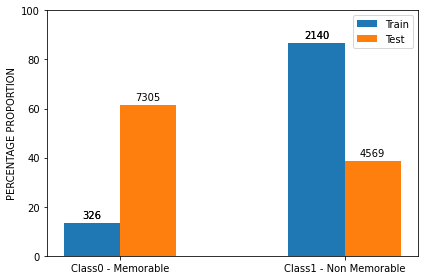

In [13]:
#@title Plot Total Data Distribution 

# BAR
plotbargraph(train_total)

# # PCA -----
# pca = PCA(n_components=2)

# hold = train_total.iloc[:,1:-1]

# X_pca = pca.fit_transform(hold)

# plot_2d_space(X_pca, train_total_y)

# len(X_pca)

In [0]:
#@title Overwrite Variable Names for ease.

train = train_total

train_observed = train.iloc[:,-1] 

y = train_total_observed.to_numpy()

<br>

In [0]:
#@title Annotation Confidence
# Merge two dataframes.
train = pd.merge(train, annotation_confidence, on='ID')
train = train[train["confidence"]==1.0]
train.drop(["confidence"], axis=1, inplace=True)

# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 

Proportions
Training data:  Class0: 2.48%   Class1: 97.52%   Proportion: 0.0254 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


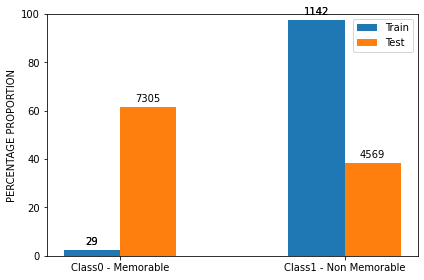

In [16]:
#@title Plot Data after factoring in Annotation Confidence

# BAR
plotbargraph(train)

# # PCA -----
# pca = PCA(n_components=2)

# hold = train.iloc[:,1:-1]

# X_pca = pca.fit_transform(hold)

# plot_2d_space(X_pca, y)

# len(X_pca)

<br>

In [17]:
#@title Using Feature Selection

X = train.iloc[:,1:-1]

# Chi^2, k=default=10.
selector = SelectKBest(chi2,k=1500)

# Fit transform training data.
X_selected = selector.fit_transform(X, y)
X_sel_df = pd.DataFrame(X_selected).reset_index()

# Transform test data.
test_sel = selector.transform(test.iloc[:,1:])
test_sel = pd.DataFrame(test_sel).reset_index()

# Reform pd.DF.
X_sel_df = pd.concat([X_sel_df,pd.DataFrame(y)],axis=1)

# Rename for over-sampling.
X_sel_df.columns = [*X_sel_df.columns[:-1], 'prediction']
X_sel_df.columns.values[0] = "ID"

# Check for GIST features.
X.iloc[:, selector.get_support()]

,CNNs,CNNs.2,CNNs.6,CNNs.8,CNNs.10,CNNs.11,CNNs.12,CNNs.14,CNNs.16,CNNs.26,CNNs.28,CNNs.30,CNNs.31,CNNs.32,CNNs.35,CNNs.41,CNNs.43,CNNs.45,CNNs.52,CNNs.57,CNNs.65,CNNs.67,CNNs.68,CNNs.69,CNNs.82,CNNs.84,CNNs.87,CNNs.88,CNNs.89,CNNs.90,CNNs.96,CNNs.97,CNNs.98,CNNs.99,CNNs.111,CNNs.113,CNNs.117,CNNs.121,CNNs.122,CNNs.124,...,CNNs.3990,CNNs.3997,CNNs.4000,CNNs.4001,CNNs.4002,CNNs.4003,CNNs.4005,CNNs.4009,CNNs.4012,CNNs.4021,CNNs.4027,CNNs.4028,CNNs.4034,CNNs.4038,CNNs.4040,CNNs.4041,CNNs.4042,CNNs.4049,CNNs.4052,CNNs.4055,CNNs.4057,CNNs.4061,CNNs.4062,CNNs.4065,CNNs.4066,CNNs.4067,CNNs.4070,CNNs.4072,CNNs.4076,CNNs.4078,CNNs.4080,CNNs.4081,CNNs.4083,CNNs.4084,CNNs.4086,CNNs.4087,CNNs.4088,CNNs.4090,CNNs.4093,CNNs.4095
2,0.000000,0.000000,0.119300,0.517480,0.062792,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,1.143300,0.000000,1.082800,0.000000,0.000000,0.190340,0.000000,0.000000,0.00000,0.324940,0.000000,0.000000,0.000,0.00000,0.152930,...,0.000000,0.000000,0.000000,0.000000,0.904320,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.698420,0.00000,0.000000,0.000000,0.000000,0.000000,0.145800,0.43357,0.000000,0.000000,0.000000,0.000000,0.082653,0.000000,1.545100,0.000000,0.49219,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.184430,0.000000,1.154700,0.0
3,0.211680,0.000000,0.000000,0.862640,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1.092700,1.927500,0.271040,1.059600,0.671550,0.000000,0.00000,0.506120,0.000000,0.031998,0.17378,0.740110,0.764410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245330,2.51020,0.106110,0.000000,0.413530,0.000,1.65660,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.604040,0.731270,0.00000,0.000000,0.578040,0.620090,0.000000,0.000000,0.000000,0.73506,0.000000,0.000000,0.000000,0.226650,0.000000,0.00000,1.132100,0.000000,0.000000,0.100540,0.000000,0.145580,0.000000,0.000000,0.00000,0.00000,0.053934,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.008473,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.779770,0.000000,0.000000,0.014181,0.000000,0.00000,0.000000,0.648880,0.000000,0.00000,0.000000,0.437480,0.000000,0.000000,0.000000,1.033600,1.408700,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.13130,0.000000,0.000000,0.000000,0.000000,0.129790,1.186900,0.00000,0.000000,0.000000,0.454540,0.000000,0.314170,0.00000,0.000000,0.000000,0.000000,0.018714,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.558230,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.240000,0.0
5,0.098998,0.000000,0.000000,1.402800,0.000000,0.00000,0.233100,0.000000,0.000000,0.526740,0.77824,0.00000,0.000000,0.000000,0.000000,0.226770,0.000000,0.000000,0.000000,0.00000,0.000000,0.068713,0.167330,0.12037,0.149910,0.000000,0.369610,0.400010,0.000000,0.000000,0.517870,0.000000,0.000000,0.00000,0.061561,0.037528,0.000000,0.000,0.00000,0.000000,...,0.138230,0.000000,0.000000,0.690960,0.209910,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.182000,0.00000,0.127750,0.298970,0.000000,0.578080,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.600900,0.0,0.279600,0.854890,0.00000,0.00000,0.488460,0.000000,0.000000,0.0
6,0.000000,0.000000,0.715220,0.405670,0.000000,0.25943,0.000000,0.069059,0.000000,0.552440,1.08150,0.37741,0.093864,0.931410,0.091697,0.000000,1.160900,1.528900,0.686370,0.39436,0.000000,0.371380,0.000000,0.17316,1.375100,0.601840,1.165300,0.000000,0.000000,1.200100,0.000000,0.030606,1.028000,0.10795,0.451200,0.462700,0.000000,0.449,0.00000,0.850500,...,0.000000,0.262130,0.472080,0.000000,0.541690,0.019572,0.10669,0.000000,0.133310,0.438040,0.349220,0.034362,0.351950,0.39465

In [18]:
#@title Up Sample Feature Selected Data

train_sel, train_obs_sel, train_y_sel = resample_up(X_sel_df)

1892 rows added to trning data with class0 scores.


Proportions
Training data:  Class0: 62.72%   Class1: 37.28%   Proportion: 1.6824 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


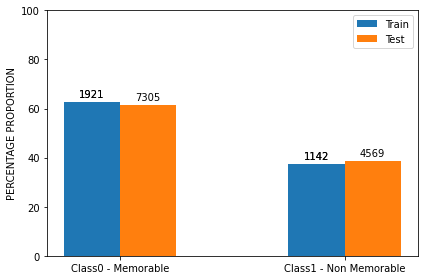

In [19]:
#@title Plot Up Sampled, Selected Distribution

plotbargraph(train_sel)

# # PCA
# pca = PCA(n_components=2)

# hold = train_sel.iloc[:,1:-1]

# X_pca = pca.fit_transform(hold)

# plot_2d_space(X_pca, train_y_sel)

# len(X_pca)

In [0]:
#@title Feature Scaling for Select Data

df_train = train_sel.iloc[:,1:-1]
vals_train = df_train.to_numpy(copy=True)

df_test = test_sel.iloc[:,1:]
vals_test = df_test.to_numpy(copy=True)

# Get mean and std. from training data.
mean = vals_train.mean()
std = vals_train.std()

# Transform training then testing data.
vals_train = (vals_train - mean) / std
vals_test = (vals_test - mean) / std

<br>

In [0]:
#@title Data Set-up

# Params:
# Feature data.
X = vals_train
# Feature test data.
test_data = vals_test
# Predictions
y = train_sel.iloc[:,-1]

In [0]:
#@title Declare list for taking predictions from diff classifier for voting system.

# Append classifier predictions into this list for averaging.
voting_list = list()

<br>

<br>

In [59]:
# Highest result

hddn_lyrs = (200,200,200,1)
mx_itr = 200

# No diff so far.
lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}


# Sklearn MLP Classifier.

clf = MLPClassifier(solver="adam",
                        activation="logistic",
                        hidden_layer_sizes=hddn_lyrs,
                        max_iter=mx_itr,
                        alpha=1e-5,
                        random_state=1,
                        learning_rate=lr["c"]
                        )

clf.fit(X,y)

# Predictions.
predictions_final = clf.predict(test_data)

estimate(predictions_final)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Class 0 Non memorable: 
Predicted proportion: 0.4835 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.5165 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
23.97%
Difference of:
0.1317


<br>

In [113]:
# AdaBoost Classifier

clf = AdaBoostClassifier(n_estimators=25, random_state=seed)

clf.fit(X,y)

# Predictions.
predictions_final = clf.predict(test_data)

estimate(predictions_final)

Class 0 Non memorable: 
Predicted proportion: 0.3878 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.6122 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
45.34%
Difference of:
0.2274


In [23]:
# Sklearn MLP Classifier.

hddn_lyrs = (200,200,200,200)
mx_itr = 100

lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}

clf = MLPClassifier(solver="adam",
                        activation="logistic",
                        hidden_layer_sizes=hddn_lyrs,
                        max_iter=mx_itr,
                        alpha=1e-5,
                        random_state=1,
                        learning_rate=lr["c"]
                        )

clf.fit(X,y)

# Predictions.
predictions_final = clf.predict(test_data)

estimate(predictions_final)

Class 0 Non memorable: 
Predicted proportion: 0.5106 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.4894 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
18.58%
Difference of:
0.1046


In [30]:
# Keras MLP

model = Sequential()
model.add(Dense(1500, input_dim=1500, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(1000, activation='relu'))
model.add(Dense(750, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy ',
              optimizer='adam',
              metrics=["accuracy"])

model.fit(X, y, epochs=4, validation_split=0.25)

predictions_final = model.predict(test_data)

predictions_final = np.around(predictions_final).flatten().astype("int")

estimate(predictions_final)

Train on 2297 samples, validate on 766 samples
Epoch 1/4
2297/2297 [==============================] - 4s 2ms/step - loss: 0.2540 - accuracy: 0.8933 - val_loss: 0.0148 - val_accuracy: 0.9961
Epoch 2/4
2297/2297 [==============================] - 3s 1ms/step - loss: 0.0756 - accuracy: 0.9800 - val_loss: 0.0158 - val_accuracy: 0.9974
Epoch 3/4
2297/2297 [==============================] - 3s 1ms/step - loss: 0.0226 - accuracy: 0.9939 - val_loss: 0.0182 - val_accuracy: 0.9961
Epoch 4/4
2297/2297 [==============================] - 3s 1ms/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.0218 - val_accuracy: 0.9948
Class 0 Non memorable: 
Predicted proportion: 0.4971 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.5029 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
21.24%
Difference of:
0.1181


In [26]:
#@title Test Classifiers

# Enter classifier Here.
classifer = clf
# Enter 1 for keras, 0 for not.
keras_model = 0
# Determine size of data split.
split_size = 0.8

vals = train_test_split(X, y,
                        test_size=split_size
                        )

classifier_performance(vals, classifer, keras_model)

Class 0 Non memorable: 
Predicted proportion: 0.6373 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.3627 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
3.53%
Difference of:
0.0221

Classification Report:
              precision    recall  f1-score   support

      Class0       0.98      1.00      0.99      1524
      Class1       1.00      0.96      0.98       927

    accuracy                           0.98      2451
   macro avg       0.99      0.98      0.98      2451
weighted avg       0.98      0.98      0.98      2451



Confusion Matrix


Predicted,0.0,1.0,All
True,,,
0.0,1524,0,1524
1.0,38,889,927
All,1562,889,2451


'\\begin{tabular}{lrrr}\n\\toprule\nPredicted &   0.0 &  1.0 &   All \\\\\nTrue &       &      &       \\\\\n\\midrule\n0.0  &  1524 &    0 &  1524 \\\\\n1.0  &    38 &  889 &   927 \\\\\nAll  &  1562 &  889 &  2451 \\\\\n\\bottomrule\n\\end{tabular}\n'

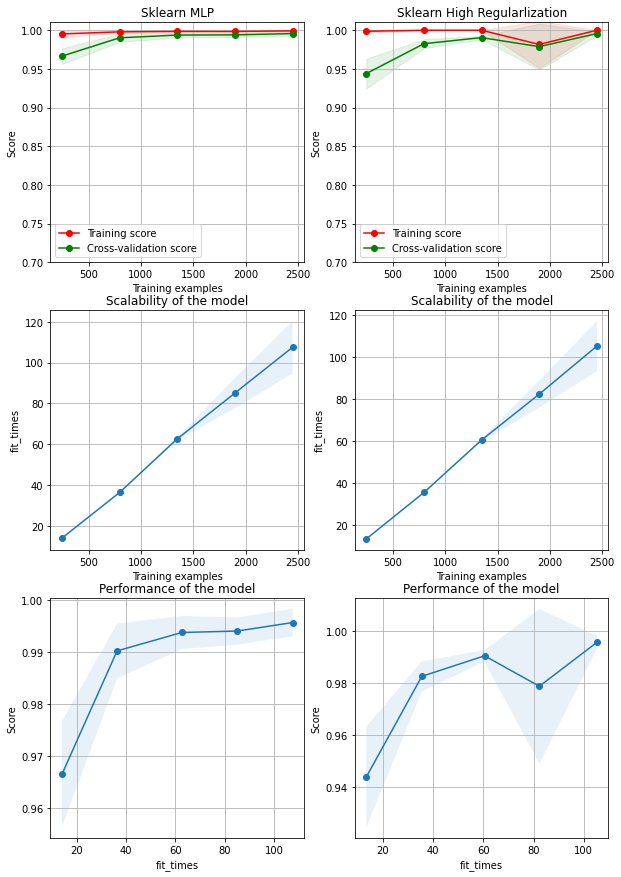

In [0]:
#@title Plot Learning Curves - Compare two models.
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Sklearn MLP"
clf1 = MLPClassifier(solver="adam",
                        activation="logistic",
                        hidden_layer_sizes=hddn_lyrs,
                        max_iter=mx_itr,
                        alpha=1e-5,
                        random_state=1,
                        learning_rate=lr["c"]
                        )
cv = ShuffleSplit(n_splits=6, test_size=0.2, random_state=seed)
plot_learning_curve(clf, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)


title = "Sklearn High Regularlization"
clf2 = MLPClassifier(solver="adam",
                        activation="logistic",
                        hidden_layer_sizes=hddn_lyrs,
                        max_iter=mx_itr,
                        alpha=0.01,
                        random_state=1,
                        learning_rate=lr["c"]
                        )
cv = ShuffleSplit(n_splits=6, test_size=0.2, random_state=seed)
plot_learning_curve(clf2, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

In [0]:
#@title Voting System:

# Average the predictions fed into the voting list.
voted_averages = np.mean(voting_list, axis=0)
predictions_final = np.around(voted_averages).astype("int")

estimate(predictions_final)

In [0]:
# Convert to INT:
predictions_final = predictions_final.astype("int")

# Create and download .csv file.
rnge = np.arange(1,len(predictions_final)+1)
df = pd.DataFrame({"ID": rnge, "prediction": predictions_final})
df.to_csv("submission1.csv", index=False)

In [25]:
# Run to submit to Kaggle competition.
!kaggle competitions submit brighton-a-memorable-city -f submission1.csv -m "woo"

100% 81.9k/81.9k [00:04<00:00, 17.2kB/s]
Successfully submitted to Brighton, a memorable city!

In [0]:
files.download("submission1.csv")

In [0]:
# 0.6152 class 0      non memorable.
# 0.3848 class 1      memorable.

### Scores:

**Sklearn MLP - Estimate Func Return: 0.5873, Kaggle: 0.76583**
* additional data 
* sklearn oversampler 
* custom standardizer

**Sklearn MLP - Estimate Func Return: 0.624, Kaggle: 0.76684**
* additional data 
* sklearn feature selection - SelectKBest(chi2,k=1500)
* sklearn oversampler 
* custom standardizer

**Keras MLP - Estimate Func Return: 0.521, Kaggle: 0.77729**
* additional data 
* annotation confidence - only 100% certainty allowed
* sklearn feature selection - SelectKBest(chi2,k=1500)
* sklearn oversampler 
* custom standardizer
* validation split 0.25
<br>(See bottom of notebook for Classifier)

**CURRENT BEST Sklearn MLP - Estimate Func Return: 0.5106, Kaggle: 0.78234**
* additional data 
* annotation confidence - only 100% certainty allowed
* sklearn feature selection - SelectKBest(chi2,k=1500)
* sklearn oversampler 
* custom standardizer



In [0]:
#@title Domain Adaptation Classifier - NOT optimized.

from libtlda.tca import TransferComponentClassifier

clf = TransferComponentClassifier()

clf.fit(X, y, test_data)

predictions_final = clf.predict(test_data)

estimate(predictions_final)

In [0]:
#@title Custom Implemented Hyper-Parameter tuning

slvr = ["adam","lbfgs","sgd"]
activations = ['identity', 'logistic', 'tanh', 'relu']

for solve in slvr:
  for act in activations:
    print("'{}' solver".format(solve))
    print("'{}' activation function".format(act))
    # MLP Classifier.
    clf = MLPClassifier(solver=solve,
                        activation=act,
                        hidden_layer_sizes=hddn_lyrs,
                        max_iter=mx_itr,
                        alpha=1e-5,
                        random_state=1,
                        learning_rate=lr["c"]
                        )

    clf.fit(X,y)

    # Predictions.
    predictions_final = clf.predict(test_data)

    estimate(predictions_final)
    print("\n\n")

# Curr score - 0.68092 - "adam"

In [0]:
#@title Model Selection
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

clfs = [RandomForestClassifier(max_features="sqrt",
                             max_depth=None,
                             min_samples_split=2
                             ),
        svm.SVC(kernel="rbf"),
        DecisionTreeClassifier(random_state=seed)
        ]

for clf in clfs:
  print(type(clf))
  clf.fit(X,y)
  predictions_final = clf.predict(test_data)
  estimate(predictions_fina l)
  print("\n\n")


<br>

Below shows:
* Old Methods
* Refactored Code 
* Not optimized pre-processing/classifiers
* Tried and failed


For these reasons below is not featured in the report but is left appended to the bottom of notebook as testament to all the different approaches possible.

In [0]:
#@title FEATURE SCALING Tester

df_train = train_sel.iloc[:,1:-1]
vals_train = df_train.to_numpy(copy=True)

df_test = test_sel.iloc[:,1:]
vals_test = df_test.to_numpy(copy=True)

# Test Scalers here.
qt = QuantileTransformer(n_quantiles=5000, random_state=0)
qt = Normalizer()
vals_train = qt.fit_transform(vals_train)
vals_test = qt.transform(vals_test)

In [0]:
#@title USING FEATURE SELECTION

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import VarianceThreshold


# X = train.iloc[:,1:-1]

# # Chi^2, k=default=10.
# selector = SelectKBest(chi2,k=6)
# selector = VarianceThreshold(threshold=(.8 * (1 - .8)))

# # Fit transform training data.
# X_selected = selector.fit_transform(X, y)
# X_sel_df = pd.DataFrame(X_selected).reset_index()

# # Transform test data.
# test_sel = selector.transform(test.iloc[:,1:])
# test_sel = pd.DataFrame(test_sel).reset_index()

# # Reform pd.DF.
# X_sel_df = pd.concat([X_sel_df,pd.DataFrame(y)],axis=1)

# # Rename for over-sampling.
# X_sel_df.columns = [*X_sel_df.columns[:-1], 'prediction']
# X_sel_df.columns.values[0] = "ID"

# # Check for GIST features.
# X.iloc[:, selector.get_support()]

In [0]:
#@title Example Split on Training Data.

# # Train on train, test on train[split].

# split_spot = 40

# train_split_train = train.iloc[:split_spot, 1:-1].to_numpy(copy=True)
# train_pred_train = train.iloc[:split_spot, -1].to_numpy(copy=True)
# print("Length match: {}".format(len(train_split_train) == len(train_pred_train)))

# train_split_test = train.iloc[split_spot: ,1:-1].to_numpy(copy=True)
# train_pred_test = train.iloc[split_spot: ,-1].to_numpy(copy=True)

# X = train_split_train
# y = train_pred_train 

# clf = MLPClassifier(solver="lbfgs", alpha=1e-5, random_state=1)

# clf.fit(X,y)

# predictions = clf.predict(train_split_test)

# accuracy = 0 

# for i, (p1,p2) in enumerate(zip(predictions, train_pred_test)):
#   if p1 == p2:
#     accuracy += 1

# print("Proportional Accuracy: {}".format(accuracy / len(predictions)))


# conf = confusion_matrix(train_pred_test, predictions)
# df = pd.DataFrame(conf)
# print(df)

# plt.imshow(conf, cmap="binary", interpolation="None")
# #plt.axis("off")
# plt.show()

In [0]:
#@title CHI^2 FEATURE SELECTION TOP FEATURES

# X = train.iloc[:,1:-1]
# # Chi^2, k=default=10.
# selector = SelectKBest(chi2,k=6)
# fit = selector.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Features:','Score']  #naming the dataframe columns
# pd.DataFrame(featureScores.nlargest(6,'Score'))

# # https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [0]:
#@title SKLEARN RESAMPLE(OVERSAMPLE) ONLY FEATURE SELECTED DATA

train_sel, train_obs_sel, train_y_sel = resample_up(X_sel_df)

3084 rows added to trning data with class0 scores.


In [0]:
#@title PLOT FEATURE SELECTED DISTIBUTION

plotbargraph(train_sel)
# PCA
pca = PCA(n_components=2)

hold = train_sel.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, train_y_sel)

len(X_pca)

In [0]:
#@title FEATURE SCALING FOR SELECT DATA

df_train = train_sel.iloc[:,1:-1]
vals_train = df_train.to_numpy(copy=True)

df_test = test_sel.iloc[:,1:]
vals_test = df_test.to_numpy(copy=True)

# Get mean and std. from training data.
mean = vals_train.mean()
std = vals_train.std()

# Transform training then testing data.
vals_train = (vals_train - mean) / std
vals_test = (vals_test - mean) / std

In [0]:
#@title SETUP PARAMETERS FOR CLASSIFIER(S) USING SELECT DATA

# Params:
# Feature data.
X = vals_train
# Feature test data.
test_data = vals_test
# Predictions
y = train_sel.iloc[:,-1]


hddn_lyrs = (100,100,100,100)
mx_itr = 100

# No diff so far.
lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}

<br>

In [0]:
#@title Using Feature Selection GIST

X_GIST = train.iloc[:,-513:-1]

# Chi^2, k=default=10.
selector = SelectKBest(chi2,k=10)

# Fit transform training data.
X_selected = selector.fit_transform(X_GIST, y)
X_sel_df_GIST = pd.DataFrame(X_selected).reset_index()

# Transform test data.
test_sel_GIST = selector.transform(test.iloc[:,-512:])
test_sel_GIST = pd.DataFrame(test_sel_GIST).reset_index()

# Reform pd.DF.
X_sel_df_GIST = pd.concat([X_sel_df_GIST,pd.DataFrame(y)],axis=1)

# Rename for over-sampling.
X_sel_df_GIST.columns = [*X_sel_df_GIST.columns[:-1], 'prediction']
X_sel_df_GIST.columns.values[0] = "ID"

# Check for GIST features.
X_GIST.iloc[:, selector.get_support()]

In [0]:
#@title Up Sample Feature Selected Data GIST

train_sel_GIST, train_obs_sel_GIST, train_y_sel_GIST = resample_up(X_sel_df_GIST)

In [0]:
#@title Feature Scaling for Select Data

df_train = train_sel_GIST.iloc[:,1:-1]
vals_train = df_train.to_numpy(copy=True)

df_test = test_sel_GIST.iloc[:,1:]
vals_test = df_test.to_numpy(copy=True)

# Get mean and std. from training data.
mean = vals_train.mean()
std = vals_train.std()

# Transform training then testing data.
vals_train = (vals_train - mean) / std
vals_test = (vals_test - mean) / std

<br>

In [0]:
#@title SKLEARN RESAMPLE(OVERSAMPLE) - TOTAL DATA

train, train_observed, train_y = resample_up(train)

In [0]:
#@title PLOT RESAMPLED DISTRIBUTION
# BAR
plotbargraph(train)

# PCA
pca = PCA(n_components=2)

hold = train.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, train_y)

len(X_pca)

In [0]:
#@title FEATURE SCALING - MANUAL STANDARDIZATION - FUNCTION

def manual_standardization(trn, tst, rtn_DF=False):
  # ------ Set up training and testing data.

  # Split standardizer by hand.
  # Training data.
  df_cnn = trn.iloc[:, 1:-513]
  df_gist = trn.iloc[:, -513:-1]

  X_cnn = df_cnn.to_numpy(copy=True)
  X_gist = df_gist.to_numpy(copy=True)

  # Testing data.
  df_test_cnn = tst.iloc[:,1:-512]
  df_test_gist = tst.iloc[:,-512:]

  test_values_cnn = df_test_cnn.to_numpy(copy=True)
  test_values_gist = df_test_gist.to_numpy(copy=True)


  # Set scale method.
  scale_setting = 1

  if scale_setting == 0:
    # Standardize training data.
    scaler = MinMaxScaler()
    X_cnn = scaler.fit_transform(X_cnn)
    test_values_cnn = scaler.transform(test_values_cnn)

    # Standardize training data.
    scaler = MinMaxScaler()
    X_gist = scaler.fit_transform(X_gist)
    test_values_gist = scaler.transform(test_values_gist)

  elif scale_setting == 1:
    # CNN scaling.
    mean = X_cnn.mean()
    std = X_cnn.std()

    X_cnn = (X_cnn - mean) / std
    test_values_cnn = (test_values_cnn - mean) / std

    # GIST scaling.
    mean = X_gist.mean()
    std = X_gist.std()

    X_gist = (X_gist - mean) / std
    test_values_gist = (test_values_gist - mean) / std


  #Create final np arrays for training/test.
  X_standardized = np.concatenate((X_cnn,X_gist),axis=1)
  test_data_standardized = np.concatenate((test_values_cnn,test_values_gist),axis=1)

  if rtn_DF:
    # Create new dataframe holding standardized data.
    reshaped_0 = pd.DataFrame(X_standardized).reset_index()
    trn_observed = trn.iloc[:, -1]
    df = pd.concat([reshaped_0,trn_observed], axis=1)
    # Rename columns for consistency. 
    df = pd.DataFrame(data=df.values, columns=trn.columns)
    return X_standardized, test_data_standardized, df

  return X_standardized, test_data_standardized

In [0]:
#@title SETUP PARAMETERS FOR CLASSIFIER(S)

# Training dataframe here (ensures predictions columns consistent)
trn_df = train

# Create scaled data.
X_standardized, test_data_standardized = manual_standardization(trn_df, test)

# Params:
# Feature data.
X = X_standardized
# Feature test data.
test_data = test_data_standardized
# Predictions
y = trn_df.iloc[:,-1]


hddn_lyrs = (100,100,100,100)
mx_itr = 100

# No diff so far.
lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}

<br>

In [0]:
#@title SKLEARN RESAMPLE (OVER-SAMPLE)
# # RESAMPLING.                             # Curr score - 0.68092
# # ----------- Up sampling minority class.

# #train = pd.read_csv("/content/training.csv")

# # Minority class.
# c = 0 
# minority = train.loc[train["prediction"] == c]

# # Num. of samples equal across classes.
# num = len(train) - 2 * len(minority)
# # Increase to match test data ratio if wanted.
# num = round(num * 1.7)

# print("{} rows added to training data with class{} scores.".format(num, c))

# class0_upsampled = resample(minority,
#                            replace=True,
#                            n_samples=num,
#                            random_state=seed
#                            )

# # Concat new class0 sample and original train.
# train = pd.concat([train, class0_upsampled])

# # Shuffle. 
# train = shuffle(train, random_state=seed)


# # Fix INDEX OF TRAIN DATA.
# train = train.reset_index(drop=True).reset_index().drop(columns=["ID"])
# train.columns.values[0] = "ID"
# train["ID"] += 1


# # Update target array.
# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)

In [0]:
#@title SKLEARN RESAMPLE (OVER-SAMPLE) USING TOTAL DATA
# # RESAMPLING.                             
# # ----------- Up sampling minority class.

# #train = pd.read_csv("/content/training.csv")

# # Minority class.
# c = 0 
# minority = train_total.loc[train_total["prediction"] == c]

# # Num. of samples equal across classes.
# num = len(train_total) - 2 * len(minority)
# # Increase to match test data ratio if wanted.
# num = round(num * 1.7)

# print("{} rows added to training data with class{} scores.".format(num, c))

# class0_upsampled = resample(minority,
#                            replace=True,
#                            n_samples=num,
#                            random_state=seed
#                            )

# # Concat new class0 sample and original train.
# train_total = pd.concat([train_total, class0_upsampled])

# # Shuffle. 
# train_total = shuffle(train_total, random_state=seed)


# # Fix INDEX OF TRAIN_total DATA.
# train_total = train_total.reset_index(drop=True).reset_index().drop(columns=["ID"])
# train_total.columns.values[0] = "ID"
# train_total["ID"] += 1


# # Update target array.
# # Get all observed predictions 0 / 1.
# train_total_observed = train_total.iloc[:, -1]
# # .values()
# train_total_y = train_total_observed.to_numpy(copy=True)

In [0]:
#@title IMBLEARN ASSORTED RESAMPLERS (OVERSAMPLING) -- SMOTE ETC.

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC
#from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import RandomOverSampler

# Reset if needed.
train = pd.read_csv("/content/training.csv")
train_observed = train.iloc[:, -1]

# vvvvvvv RUN AND SUBMIT THIS LAST ONE vvvvvvv
ovrsmplr = RandomOverSampler(random_state=seed)

X_res, _ = ovrsmplr.fit_resample(train, train_observed)
print("{} rows added to training data with class0 scores.\n".format(len(X_res)-len(train)))
train = pd.DataFrame(X_res)

train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 

In [0]:
#@title IMBLEARN SMOTE (OVER-SAMPLE)

from imblearn.over_sampling import SMOTE

# Train Data here.
trn = train

# Create SMOTE resampler.
sm = SMOTE(random_state=seed)

# resample(TrainDataOnly, PredictionsOnly)
X_res, y_res = sm.fit_resample(trn.iloc[:,:-1], trn.iloc[:,-1])
# X_res holds data without predictions, y_res is predictions.

X_df = pd.DataFrame(X_res)
y_df = pd.DataFrame(y_res)

# USE TRAIN ONWARDS.
# Concat to mimic og. train.
holder = pd.concat([X_df,y_df], axis=1)
train = pd.DataFrame(data=holder.values, columns=trn.columns)
# Predictions.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 

In [0]:
#@title SMOTETOMEK COMBINE RESAMPLER
# from imblearn.combine import SMOTETomek

# v_curr = len(train)

# gg = train.iloc[:,1:-1]

# smt = SMOTETomek(ratio='auto', random_state=seed)
# X_smt, y_smt = smt.fit_resample(gg, train_observed)

# df_X_smt = pd.DataFrame(X_smt)
# df_y_smt = pd.DataFrame(y_smt)

# df_total = pd.concat([df_X_smt,df_y_smt], axis=1)


# train = df_total.reset_index()

# v_curr = len(train) - v_curr
# print("{} rows added to training data".format(v_curr))

# # Shuffle. 
# train = shuffle(train, random_state=seed)

# # Update target array.
# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)

In [0]:
#@title SMOTEEEN COMBINE RESAMPLER
# from imblearn.combine import SMOTEENN

# v_curr = len(train)

# gg = train.iloc[:,1:-1]

# smt = SMOTEENN(ratio='auto', random_state=seed)
# X_smt, y_smt = smt.fit_resample(gg, train_observed)

# df_X_smt = pd.DataFrame(X_smt)
# df_y_smt = pd.DataFrame(y_smt)

# df_total = pd.concat([df_X_smt,df_y_smt], axis=1)


# train = df_total.reset_index()

# v_curr = len(train) - v_curr
# print("{} rows added to training data".format(v_curr))

# # Shuffle. 
# train = shuffle(train, random_state=seed)

# # Update target array.
# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)

In [0]:
#@title TOMEKS LINKS UNDERSAMPLING METHODS.
# Tomeks links --------------------

# # RESAMPLING.
# # ---------- Remove from majority class.

# # Removing TomekLinks.
# df_cnn = train.iloc[:, 1:-513]
# df_gist = train.iloc[:, -513:-1]

# # CNN features.
# t1 = TomekLinks(return_indices=True, ratio="majority")
# X_t1, y_t1, id_t1 = t1.fit_resample(df_cnn, train_observed)

# # GIST features.
# t2 = TomekLinks(return_indices=True, ratio="majority")
# X_t2, y_t2, id_t2 = t2.fit_resample(df_gist, train_observed)

# # List to hold Tomek's links indicies.
# index_removal = list()
# for index in np.arange(len(train)):
#   if index in id_t1:
#     pass
#   else:
#     index_removal.append(index)
#   if index in id_t2:
#     pass
#   else:
#     index_removal.append(index)


# # Remove specified indicies from train.
# train = train.drop(index_removal)

# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)


# print("{} rows removed from train.target['class1'] majority class.".format(len(index_removal)))

<br>

In [0]:
#@title GROUPED TWIN AXIS BAR PLOT


# # Data representation:

# # Training ---
# trn_c0 = np.count_nonzero(y == 0)
# trn_c1 = np.count_nonzero(y == 1)

# plsdeleteAFTER = [trn_c0,trn_c1] #########
# autolabel_vals = [trn_c0,trn_c1] # Hold vals for rect labels.

# trn_c0 = round((trn_c0/len(y)*100),2)
# trn_c1 = round((trn_c1/len(y)*100),2)
# trn_bar = [trn_c0,trn_c1] # Hold vals for bar plot.


# # Testing ---
# tst_c0 = float(test_proportions.iloc[0,0][:6])

# # Hold vals for rect labels.
# autolabel_vals.append(tst_c0*len(test))
# autolabel_vals.append((1-tst_c0)*len(test))
# plsdeleteAFTER = [tst_c0*len(test),(1-tst_c0)*len(test)] #####

# tst_c0 = round((tst_c0*100),2)
# tst_c1 = 100 - tst_c0
# tst_bar = [tst_c0,tst_c1] # Hold vals for bar plot.


# print("Proportions")
# print("Training data:  Class0: {}%   Class1: {}%".format(trn_c0,trn_c1) +
#       "   Proportion: {} : 1".format(round((trn_c0/trn_c1),4)))
# print("Testing data:   Class0: {}%   Class1: {}%".format(tst_c0,tst_c1) + 
#       "   Proportion: {} : 1".format(round((tst_c0/tst_c1),4)))


# # Bar Plot.
# labels = ["Class0 - Memorable", "Class1 - Non Memorable"]
# x = np.arange(len(labels))
# width = 0.25

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, trn_bar, width, label='Train')
# rects2 = ax.bar(x + width/2, tst_bar, width, label='Test')

# colour = "tab:blue"
# ax.set_ylabel("TRAINING DATA", color=colour)
# ax.set_ylim([0,100])
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# ax2 = ax.twinx()
# colour = "tab:orange"
# ax2.set_ylabel("TESTING DATA", color=colour)
# ax2.tick_params(axis="y", color=colour)

# ############
# # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
# def autolabel(rects):
#   for i, rect in enumerate(rects):
#     height = rect.get_height()
#     ax.annotate('{}%'.format(height),
#                 xy=(rect.get_x() + rect.get_width() / 2, height),
#                 xytext=(0, 3),  # 3 points vertical offset
#                 textcoords="offset points",
#                 ha='center', va='bottom')
# ############


# autolabel(rects1)
# autolabel(rects2)

# fig.tight_layout()

# plt.show()

<BR>

In [0]:
#@title PIPELINE SET UP & RUN

# # PIPELINE
# clf = make_pipeline(MLPClassifier(solver="lbfgs",
#                                                                             hidden_layer_sizes=hddn_lyrs,
#                                                                             max_iter=mx_itr,
#                                                                             alpha=1e-5,
#                                                                             random_state=1,
#                                                                             learning_rate=lr["c"]))
# clf.fit(X, y)

# predictions_final = clf.predict(test_data)

# estimate(predictions_final)

# clf.steps

In [0]:
#@title CUSTOM FUNCTION TRANSFORMERS FOR PIPELINE

# from sklearn.preprocessing import FunctionTransformer

# def example_func(X):
#   X + 1
#   return X

# transformer = FunctionTransformer(example_func)
# X = np.array([[0, 1], [2, 3]])
# transformer.transform(X)

<BR>

In [0]:
# @title MAXABS - SCALER

# from sklearn.preprocessing import MaxAbsScaler

# scaler = MaxAbsScaler()
# X = scaler.fit_transform(X)
# test_data = scaler.transform(test_data)

<BR>

In [0]:
#@title SKLEARN RANDOM FOREST CLF

from sklearn.ensemble import RandomForestClassifier

# RANDOMFOREST Classifier.
clf = RandomForestClassifier(max_features="sqrt",
                             max_depth=None,
                             min_samples_split=2
                             )

clf.fit(X,y)

predictions_final = clf.predict(test_data)

estimate(predictions_final)

In [0]:
#@title SKLEARN SVM CLF
from sklearn import svm

# SVM Classifier.

clf = svm.SVC(kernel="sigmoid")

clf.fit(X,y)

predictions_final = clf.predict(test_data)

estimate(predictions_final)

# https://scikit-learn.org/stable/modules/svm.html

In [0]:
#@title SKLEARN DECISION TREE CLF

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=seed)

clf.fit(X,y)

# Predictions.
predictions_final = clf.predict(test_data)

estimate(predictions_final)

In [0]:
#@title SKLEARN DECISION TREE CLF - GRAPHICAL TREE REP
# from sklearn import tree

# clf = tree.DecisionTreeClassifier(random_state=seed)

# clf = clf.fit(X,y)

# tree.plot_tree(clf.fit(X,y))

In [0]:
#@title KERAS MLP APPROX SCORE 0.76 (MAYBE)

# Yields a decent score however an incredibily large number of hidden layers/ neurons - probably not justifiable.

from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(1536, input_dim=4608, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1536, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1536, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y,
          epochs=30)
        # , batch_size=4608)
# score = model.evaluate(x_test, y_test, batch_size=4608)



predictions_final = model.predict(test_data)
print(predictions_final)

predictions_final = np.around(predictions_final).flatten().astype("int")

estimate(predictions_final)

In [0]:
#@title KERAS MLP 0.77729

# Yields a decent score however an incredibily large number of hidden layers/ neurons - probably not justifiable.

from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(1500, input_dim=1500, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(1000, activation='relu'))
model.add(Dense(750, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, epochs=4, validation_split=0.25)
# score = model.evaluate(x_test, y_test, batch_size=4608)



predictions_final = model.predict(test_data)

predictions_final = np.around(predictions_final).flatten().astype("int")

estimate(predictions_final)

# #https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw